In [1]:
import numpy as np

import albumentations as A
import cv2
from matplotlib import pyplot as plt
import os
import pandas as pd
import torch
import torchvision

from pathlib import Path
from PIL import Image
from torch import Tensor
from torchvision import transforms as T
from tqdm.notebook import tqdm
from typing import Callable, Iterable, List, Optional, Tuple, Union

In [2]:
DATA_DIR = Path('/media/dmitry/data/global-wheat-detection')

In [3]:
df = pd.read_csv(DATA_DIR/'train.csv')

In [4]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [5]:
# image_id = str(df.loc[0, 'image_id'])
image_id = str(df.iloc[0, 0])
path = DATA_DIR/'train'/(image_id + '.jpg')
print(path)
# Image.open(path)

/media/dmitry/data/global-wheat-detection/train/b6ab77fd7.jpg


In [6]:
image = cv2.imread(str(path), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
img_annots = df[df['image_id'] == image_id]
img_annots.head(3)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1


In [8]:
def draw_boxes(image: np.ndarray, bboxes: Iterable[np.ndarray]):
    for bb in bboxes:
        if isinstance(bb, tuple):
            bb = tuple(map(int, bb))
        elif isinstance(bb, np.ndarray):
            bb = bb.astype(int)
        cv2.rectangle(image, tuple(bb[:2]), tuple(bb[2:]), (255, 0, 0), 1)

In [9]:
def make_dataset(image_dir: str, filenames: Iterable[str]) -> List[str]:
    image_dir = os.path.expanduser(image_dir)
        
    if not os.path.isdir(image_dir):
        raise RuntimeError("Unable to read folder {}".format(image_dir))
        
    images = [os.path.join(image_dir, fname) for fname in filenames]
    return images


def cv2_imread(path: Union[str, Path]) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def read_bbox(bbox: str) -> List[int]:
    bb = map(float, bbox[1:-1].split(','))
    bb = list(bb)
    # bb = list(map(int, bb))
    if len(bb) < 4:
        raise ValueError("Dumb bbox: {}".format(bbox))
        
    x0, y0, w, h = bb
    x1, y1 = x0 + w, y0 + h
    return x0, y0, x1, y1


def bbox_str_to_tensor(bbox: str, dtype=torch.int16) -> Tensor:
    return torch.tensor(read_bbox(bbox), dtype=dtype)


def bbox_str_to_numpy(bbox: str, dtype=np.uint16) -> np.ndarray:
    return np.array(read_bbox(bbox), dtype=dtype)

In [10]:
class WheatDataset(torchvision.datasets.VisionDataset):
    def __init__(self, image_dir, csv, transforms=None, transform=None, target_transform=None):
        super(WheatDataset, self).__init__(image_dir, transforms, transform, target_transform)
        
        df = pd.read_csv(csv)
        ids = df['image_id'].unique()[:10]
        filenames = map(lambda x: x + '.jpg', ids)
        self.images = make_dataset(image_dir, filenames)
        
        all_bboxes = []
        for image_id in tqdm(ids, desc="Parsing bboxes..."):
            bboxes = df.loc[df['image_id'] == image_id, 'bbox']
            bboxes = np.stack(list(map(bbox_str_to_numpy, bboxes)))
            # bboxes = list(map(read_bbox, bboxes))
            all_bboxes.append(bboxes)
        
        self.annotations = all_bboxes
        
    def __getitem__(self, index):
        path = self.images[index]
        bboxes = self.annotations[index]
        
        image = cv2_imread(path)
        # self.transforms is not supported due to albumentations interface
        # if self.transform is not None:
            
        return image, bboxes

    def __len__(self):
        return len(self.images)

In [11]:
%%time

image_dir = DATA_DIR/'train'
csv_path = DATA_DIR/'train.csv'

ds = WheatDataset(image_dir, csv_path)


CPU times: user 3.61 s, sys: 93.4 ms, total: 3.71 s
Wall time: 205 ms


In [12]:
tfms = [
    A.Resize(512, 512, interpolation=cv2.INTER_AREA)
]

tfms = A.Compose(tfms, bbox_params={'format': 'pascal_voc', 'label_fields': ['bboxes']})

[array([124, 273, 183, 346], dtype=uint16), array([ 688,  939,  749, 1024], dtype=uint16), array([639, 674, 722, 715], dtype=uint16), array([562, 410, 658, 493], dtype=uint16), array([665,  92, 761, 170], dtype=uint16), array([  0, 317, 103, 455], dtype=uint16), array([681, 260, 771, 317], dtype=uint16), array([621, 430, 738, 501], dtype=uint16), array([291,  28, 366,  97], dtype=uint16), array([687, 523, 756, 623], dtype=uint16), array([822, 532, 931, 601], dtype=uint16), array([  0, 178,  93, 259], dtype=uint16), array([ 41, 428, 133, 540], dtype=uint16), array([ 61, 443, 140, 552], dtype=uint16), array([181, 620, 266, 676], dtype=uint16), array([  0, 706,  84, 809], dtype=uint16), array([ 77, 717, 140, 815], dtype=uint16), array([314, 828, 363, 910], dtype=uint16), array([154, 905, 228, 990], dtype=uint16), array([  25,  943,  135, 1024], dtype=uint16), array([  96,  954,  186, 1024], dtype=uint16), array([686, 836, 765, 894], dtype=uint16), array([923, 378, 981, 424], dtype=uint16)

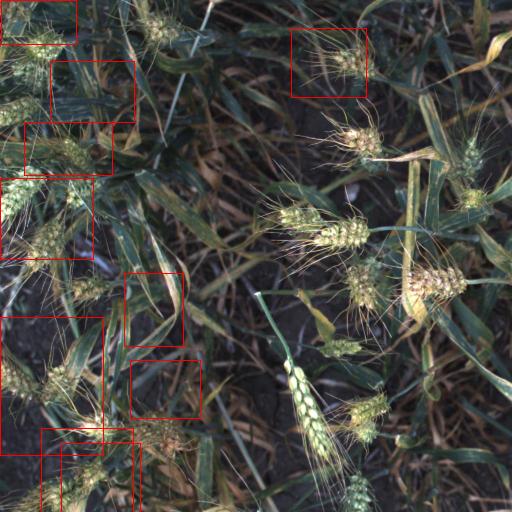

In [13]:
image, bboxes = ds[3]
out = tfms(image=image, bboxes=bboxes)
image, bboxes = out['image'], out['bboxes']
print(bboxes)

draw_boxes(image, bboxes)
Image.fromarray(image)

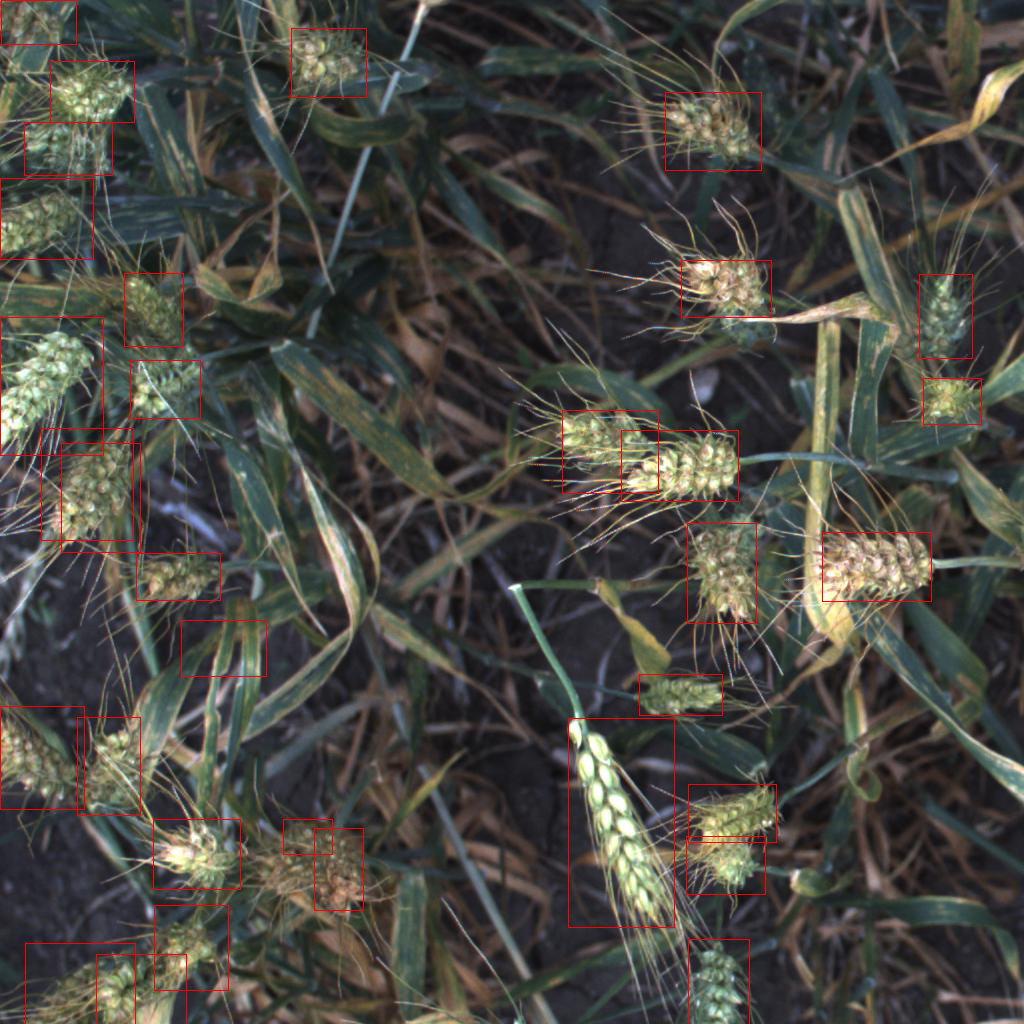

In [14]:
image, bboxes = ds[3]
draw_boxes(image, bboxes)
Image.fromarray(image)